In [1]:
import os
import os.path as osp
import time

import numpy as np
import pygmo as pg
from PIL import Image

from lpf.data import load_model_dicts
from lpf.data import load_custom_targets
from lpf.solvers import SolverFactory
from lpf.search import EvoSearch
from lpf.objectives import ObjectiveFactory
from lpf.models import ModelFactory
from lpf.converters import ConverterFactory

In [2]:
LPF_REPO_HOME = osp.abspath("..")
LPF_REPO_HOME

'/home/dwlee/repos/lpf'

In [3]:
# Create a model.
dx = 0.1
width = 128
height = 128
n_init_pts = 25

model = ModelFactory.create(
    name="Liaw",
    n_init_pts=n_init_pts,
    width=width,
    height=height,                 
    dx=dx
)

In [4]:
# Create a solver.
dt = 0.01
n_iters = 500000
solver = SolverFactory.create(name="Euler", dt=dt, n_iters=n_iters)

In [5]:
# Create a converter.
converter = ConverterFactory.create("LiawInitializer")

In [6]:
# Create objectives.
obj_config = [
    ['MeanMeanSquareError', '1e-1', 'cpu'],
    ['MeanColorProportion', '1e0', 'cpu'],
    ['MeanVgg16PerceptualLoss', '1e-4', 'cuda:0'],
    ['MeanLearnedPerceptualImagePatchSimilarity:vgg', '1.5e1', 'cuda:0'],
    ['MeanLearnedPerceptualImagePatchSimilarity:alex', '4e0', 'cuda:0']
]

objectives = ObjectiveFactory.create(obj_config)

[OBJECTIVE DEVICE] MeanMeanSquareError: cpu
[OBJECTIVE DEVICE] MeanColorProportion: cpu
[OBJECTIVE DEVICE] MeanVgg16PerceptualLoss: cuda:0
[OBJECTIVE DEVICE] MeanLearnedPerceptualImagePatchSimilarity:vgg: cuda:0


/home/dwlee/softwares/anaconda3/envs/lpf/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dwlee/softwares/anaconda3/envs/lpf/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[OBJECTIVE DEVICE] MeanLearnedPerceptualImagePatchSimilarity:alex: cuda:0


/home/dwlee/softwares/anaconda3/envs/lpf/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[TARGET] cospicua01.png has been added...


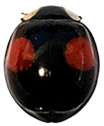

In [7]:
# Load the target laybirds.
targets = load_custom_targets("../lpf/data/haxyridis/photo", "spectabilis")

for img in targets:    
    display(img)


In [8]:
# Create an evolutionary search problem.
droot_output = osp.join("./output")

search = EvoSearch(model=model,
                   solver=solver,
                   converter=converter,
                   targets=targets,
                   objectives=objectives,
                   droot_output=droot_output)

prob = pg.problem(search)

In [9]:
dpath_init_pop = osp.join(LPF_REPO_HOME, "population", "init_pop_axyridis")  
model_dicts = load_model_dicts(dpath_init_pop)

In [10]:
t_beg = time.time()

# Create the initial population.
pop_size = 16  # We set population size = 16.
pop = pg.population(prob)
dvs = []

# Initialize the population with axyridis subtype.
for i, param_dict in enumerate(model_dicts):
    if i >= pop_size:
        break

    dv = converter.to_dv(param_dict, n_init_pts)
    dvs.append(dv)

# Adding decision vectors incorporates evaluating the fitness score.
for i, dv in enumerate(dvs):
    print(f"[DECISION VECTOR #{i+1}]\n", dv)

    # pop.set_x(i, dv)      
    pop.push_back(dv) 

# end of for

t_end = time.time()

print("[POPULATION INITIALIZATION COMPLETED]")
print("- DURATION OF INITIALIZING POPULATION: %.3f sec."%(t_end - t_beg))
print(pop)

[DECISION VECTOR #1]
 [-3.30103    -1.12493874 -0.74472749 -1.54152514 -0.69897    -3.01175246
 -1.60205999 -1.09691001  0.30103     0.         40.         10.
 40.         30.         40.         50.         21.         70.
 40.         90.         50.         10.          8.         30.
 50.         50.         50.         70.         50.         90.
 60.         10.         60.         30.         60.         50.
 60.         70.         60.         90.         13.         10.
 70.         30.         70.         50.         70.         70.
 70.         90.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
[DECISION VECTOR #2]
 [-3.30103    -1.12493874 -0.74472749 -1.54152514 -0.69897    -3.01175246
 -1.60205999 -1.09691001  0.30103     0.         40.         10.
 40.         30.         40.         50.         29.         70.
 40.         90.         50.         10.         50.         30.
 50.         50.     

In [11]:
# Create an evolutionary algorithm.
n_procs = 8
n_gen = 10000

udi = pg.mp_island()
udi.resize_pool(n_procs)

algo = pg.algorithm(pg.sade(gen=1))
isl = pg.island(algo=algo, pop=pop, udi=udi)
print(isl)

Island name: Multiprocessing island
	C++ class name: pybind11::object

	Status: idle

Extra info:
	Using a process pool: yes
	Number of processes in the pool: 8

Algorithm: saDE: Self-adaptive Differential Evolution

Problem: <class 'lpf.search.evosearch.EvoSearch'>

Replacement policy: Fair replace

Selection policy: Select best

Population size: 16
	Champion decision vector: [-3.30103, -1.12494, -0.744727, -1.55253, -0.69897, ... ]
	Champion fitness: [13.747]



In [ ]:
# Start seraching.
try:
    for i in range(n_gen):
        t_beg = time.time()
        isl.evolve()
        isl.wait_check()
        t_end = time.time()

        print("[EVOLUTION #%d] Best objective: %f (%.3f sec.)"%(i + 1, pop.champion_f[0], t_end - t_beg))

        # Save the best.
        pop = isl.get_population()
        search.save("best", pop.champion_x, generation=i+1, fitness=pop.champion_f[0])

        # Save the population.
        arr_x = pop.get_x()
        arr_f = pop.get_f()
        for j in range(arr_x.shape[0]):
            x = arr_x[j]
            fitness = arr_f[j, 0]
            search.save("pop", x, generation=i+1, fitness=fitness)
    # end of for
except Exception as err:
    print(err)
    udi.shutdown_pool()
    raise err


print("[EVOLUTIONARY SEARCH COMPLETED]")
udi.shutdown_pool()

[EVOLUTION #1] Best objective: 13.746951 (954.920 sec.)
[EVOLUTION #2] Best objective: 13.746951 (1115.807 sec.)
[EVOLUTION #3] Best objective: 13.692491 (970.680 sec.)
[EVOLUTION #4] Best objective: 13.321673 (969.613 sec.)
[EVOLUTION #5] Best objective: 13.321673 (836.523 sec.)
[EVOLUTION #6] Best objective: 12.752504 (1661.469 sec.)
[EVOLUTION #7] Best objective: 12.752504 (1100.992 sec.)
[EVOLUTION #8] Best objective: 12.752504 (829.146 sec.)
[EVOLUTION #9] Best objective: 12.712652 (1216.299 sec.)
[EVOLUTION #10] Best objective: 12.712652 (1084.754 sec.)
[EVOLUTION #11] Best objective: 12.588559 (957.286 sec.)
[EVOLUTION #12] Best objective: 12.588559 (1360.863 sec.)
[EVOLUTION #13] Best objective: 12.588559 (1337.178 sec.)
[EVOLUTION #14] Best objective: 12.588559 (1273.727 sec.)
[EVOLUTION #15] Best objective: 12.588559 (1283.759 sec.)
[EVOLUTION #16] Best objective: 12.588559 (1247.595 sec.)
[EVOLUTION #17] Best objective: 12.588559 (1487.068 sec.)
[EVOLUTION #18] Best objectiv